<a href="https://colab.research.google.com/github/Ishi-ka117/image_denoising_/blob/main/IMAGE_DENOISING_USING_CONVOLUTIONAL_AUTOENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LIBRARIES

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split
import cv2
import glob


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


LOAD LOW AND HIGH RESOLUTIONS DATA

In [3]:
def load_images(image_dir, image_size):
    images = []
    for img_path in glob.glob(os.path.join(image_dir, '*.png')):
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        img=img/255.0
        images.append(img)
    return np.array(images)

In [4]:
image_size = (128,128)
batch_size = 128
epochs = 50
learning_rate = 1e-4

DATA LOADING AND NORMALIZING

In [5]:
low_res_images_path = '/content/drive/MyDrive/Train/Train/low'
high_res_images_path = '/content/drive/MyDrive/Train/Train/high'

In [6]:

low_res_images = load_images(low_res_images_path,image_size)
high_res_images = load_images(high_res_images_path, image_size)

In [7]:
low_res_images.shape
high_res_images.shape

(485, 128, 128, 3)

DATA SPLITING INTO TRAIN TEST

In [8]:
low_res_train, low_res_val, high_res_train, high_res_val = train_test_split(
    low_res_images, high_res_images, test_size=0.4,train_size=0.6, random_state=42)

low_res_test=low_res_val

Convolutional Autoencoder

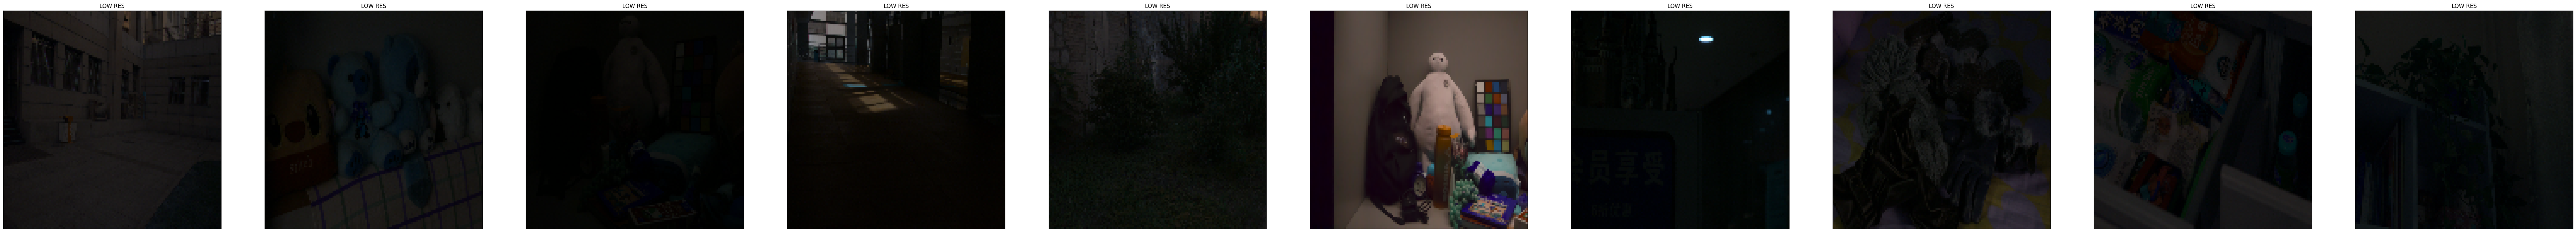

In [12]:
n=10
plt.figure(figsize=(100,20))
for i in range(n):
  ax=plt.subplot(2,n,i+1)
  plt.imshow(low_res_val[i])
  plt.title('LOW RES')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [13]:
latent_dim=64
class ConvAutoencoder(Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(512, (3, 3), activation='relu', padding='same', strides=2),
        ])
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(512, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded




autoencoder = ConvAutoencoder()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:

autoencoder.fit( low_res_train, high_res_train,
                epochs=50,
                batch_size = 64,
                shuffle=True,
                validation_data=( low_res_val,  high_res_val))

Epoch 1/50
5/5 [==============================] - 24s 2s/step - loss: 0.0497 - val_loss: 0.0491
Epoch 2/50
5/5 [==============================] - 1s 298ms/step - loss: 0.0490 - val_loss: 0.0482
Epoch 3/50
5/5 [==============================] - 2s 346ms/step - loss: 0.0480 - val_loss: 0.0474
Epoch 4/50
5/5 [==============================] - 1s 294ms/step - loss: 0.0461 - val_loss: 0.0438
Epoch 5/50
5/5 [==============================] - 1s 289ms/step - loss: 0.0434 - val_loss: 0.0417
Epoch 6/50
5/5 [==============================] - 1s 275ms/step - loss: 0.0424 - val_loss: 0.0393
Epoch 7/50
5/5 [==============================] - 1s 280ms/step - loss: 0.0404 - val_loss: 0.0395
Epoch 8/50
5/5 [==============================] - 1s 272ms/step - loss: 0.0380 - val_loss: 0.0394
Epoch 9/50
5/5 [==============================] - 1s 271ms/step - loss: 0.0366 - val_loss: 0.0376
Epoch 10/50
5/5 [==============================] - 1s 278ms/step - loss: 0.0348 - val_loss: 0.0336
Epoch 11/50
5/5 [====

In [16]:
print(autoencoder.encoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 512)         1180160   
                                                                 
Total params: 1550976 (5.92 MB)
Trainable params: 1550976 (5.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [17]:
print(autoencoder.decoder.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 16, 16, 512)       2359808   
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       1179904   
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 64, 64, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 128, 128, 64)      73792     
 Transpose)                                                      
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 3)      

In [18]:
encoded_imgs = autoencoder.encoder(low_res_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

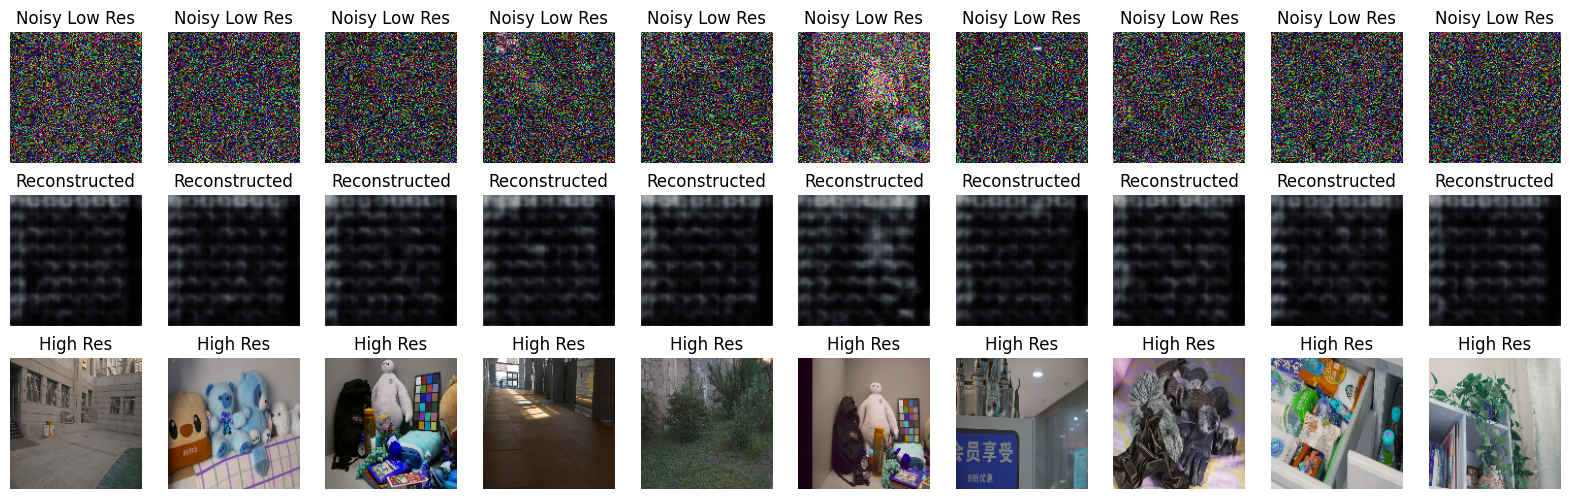

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
# Display original
ax = plt.subplot(3, n, i + 1)
plt.imshow(low_res_val[i])
plt.title("Low Res")
plt.axis('off')

# Display reconstructed
ax = plt.subplot(3, n, i + 1 + n)
plt.imshow(decoded_imgs[i])
plt.title("Reconstructed")
plt.axis('off')

# Display high-res ground truth
ax = plt.subplot(3, n, i + 1 + 2 * n)
plt.imshow(high_res_val[i])
plt.title("High Res")
plt.axis('off')

plt.show()

In [ ]:
encoded_train_imgs = autoencoder.encoder(high_res_train).numpy()
decoded_train_imgs = autoencoder.decoder(encoded_train_imgs).numpy()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(noisy_original, noisy_reconstructed):
    mse = mean_squared_error(noisy_original.flatten(), noisy_reconstructed.flatten())
    if mse == 0:
        return 100  # PSNR is infinite if MSE is zero
    max_pixel = 1.0  # Assuming pixel values are normalized to [0, 1]
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
mse_train = mean_squared_error(high_res_train.flatten(), decoded_train_imgs.flatten())
psnr_train = PSNR(high_res_train, decoded_train_imgs)
mae_train = mean_absolute_error(high_res_train.flatten(), decoded_train_imgs.flatten())

In [ ]:
mse_train


In [ ]:
psnr_train


In [ ]:
mae_train

In [ ]:
# Generate predictions for test data
predicted_images = autoencoder.predict(low_res_test)

# Save predicted images
output_dir = './test/predicted/'
os.makedirs(output_dir, exist_ok=True)

for i, img in enumerate(predicted_images):
    cv2.imwrite(os.path.join(output_dir, f'predicted_{i}.png'), cv2.cvtColor(img * 255, cv2.COLOR_RGB2BGR))
print(f"Predicted images saved to {output_dir}")

In [ ]:
predicted_dir = './test/predicted/'

# List all the files in the directory
predicted_files = os.listdir(predicted_dir)

# Number of images to display
num_images_to_display = 10

# Plot the images
plt.figure(figsize=(20, 4))
for i, file_name in enumerate(predicted_files[:num_images_to_display]):
    img_path = os.path.join(predicted_dir, file_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    # Display the image
    ax = plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.title(file_name)
    plt.axis('off')

plt.show()